# Disaster Tweets from Kaggle
NLP, `txt -> nums -> modelling -> find patterns -> use patterns make predictions`

1. Download dataset, import helper functions
2. Visualize txt data
3. Convert txt to nums using `tokenization`
4. Modelling txt dataset, start with baseline (TF-IDF), then (Dense, LSTM, GRU, Conv1D, TL-USE)
5. Compare performance
6. Combine to Ensemble
7. Save and Load
8. Find most wrong predictions (Find Patterns)

Dataset [here](https://www.kaggle.com/competitions/nlp-getting-started/data)

# 0. Check version

In [1]:
import datetime
print(f'Datetime last run (end-to-end): {datetime.datetime.now()}')

Datetime last run (end-to-end): 2024-09-05 09:39:50.264773


In [2]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_hub as hub
print(hub.__version__)

2.14.0
0.15.0


In [3]:
!pip install tensorflow==2.14.0
!pip install tensorflow_hub==0.15.0

# 1. Download Dataset and Helper Function

In [4]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
!unzip "nlp_getting_started.zip"

--2024-09-05 09:40:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-09-05 09:40:01 (148 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]

Archive:  nlp_getting_started.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, calculate_results

--2024-09-05 09:43:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-05 09:43:12 (121 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



# 2. Visualize Txt Data
2.1 DataFrame

In [6]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


2.2 Shuffle

In [7]:
# Shuffle
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


2.3 Check Value Counts

In [10]:
print(f'Training: {len(train_df)}')
print(f'Test: {len(test_df)}')
print(f'Total: {len(train_df) + len(test_df)}')

Training: 7613
Test: 3263
Total: 10876


2.4 Visualize random samples

In [11]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", " (real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1  (real disaster)
Text:
Burning buildings? Media outrage? http://t.co/pHixZnv1YN

---

Target: 0 (not real disaster)
Text:
Has An Ancient Nuclear Reactor Been Discovered In Africa? ÛÒ Your... http://t.co/qadUfO8zXg

---

Target: 1  (real disaster)
Text:
@JoeDawg42 TOR for a TOR situation only. Wind damage enhanced wording is key IMO

---

Target: 1  (real disaster)
Text:
@followlasg This is urgentthere is currently a 3 storey building at church B/stop Oworoshoki Third mainland bridge which likely to collapse

---

Target: 0 (not real disaster)
Text:
Vampiro going through the table of flames #UltimaLucha #LuchaUnderground @Elreynetwork http://t.co/Ox6OUw3Yut

---



2.5 Split train validation

In [12]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
train_sentences[:5], train_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array([0, 0, 1, 0, 0]))

# 3. Convert txt to nums

3.1 Tokenization, or Txt Vectorization

In [14]:
# Find avg num of tokens in training
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [15]:
max_vocab_length = 10000
max_length = 15
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    output_mode='int',
                                                    output_sequence_length=max_length)

In [22]:
# # Test
# x = "This is a test string"
# text_vectorizer([x])

In [23]:
# random_sentence = random.choice(train_sentences)
# print(f'Ori: \n{random_sentence}\
#         \n\nVectorized:\n')
# text_vectorizer([random_sentence])

3.2 Fit vectorizer to training txt

In [18]:
text_vectorizer.adapt(train_sentences)

3.3 Get unique tokens in vocabulary

In [19]:
x = text_vectorizer.get_vocabulary()
print(f'The most common tokens: {x[:5]}')
print(f'The least common tokens: {x[-5:]}')

The most common tokens: ['', '[UNK]', 'the', 'a', 'in']
The least common tokens: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


3.4 Create Embedding (Necessary Step after Tokenization)

In [20]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, #set size of embedding vector
                             embeddings_initializer='uniform',
                             input_length=max_length,
                             name='embedding_1')
embedding

In [21]:
# Test Embedding
x = random.choice(train_sentences)
print(f'Ori: \n{x}\n\nEmbed: \n')
embed = embedding(text_vectorizer([x]))
embed

Ori: 
I rate Hazard very highly but his fanboys are among the worst accounts on Twitter.

Embed: 



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02999791,  0.01353354,  0.02512889, ...,  0.0238279 ,
          0.01695898,  0.00790765],
        [ 0.02599424, -0.00291627,  0.02739957, ...,  0.04852165,
          0.02674246,  0.01971037],
        [ 0.01203029, -0.0348192 ,  0.02910173, ...,  0.04879539,
         -0.03489262, -0.03113045],
        ...,
        [ 0.01808751, -0.02142025,  0.03792268, ..., -0.02101108,
          0.01400835,  0.02585338],
        [ 0.03249134,  0.01750991,  0.00854324, ..., -0.04265243,
          0.04981634,  0.03940091],
        [-0.03744525, -0.00429044, -0.00649953, ..., -0.03889558,
          0.04989077, -0.00033995]]], dtype=float32)>

#4. Modelling txt dataset

4.1 Model-0: Baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

baseline_score = model_0.score(val_sentences, val_labels)
print(f'Baseline model accuracy: {baseline_score*100:.2f}%')

Baseline model accuracy: 79.27%


4.1.1 Make Predictions

In [25]:
# Make Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:5]

array([1, 1, 1, 0, 0])

In [26]:
baseline_results = calculate_results(val_labels,
                                     baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

4.2 Model-1: Dense

In [27]:
# Create directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

# Functional API below
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

# # Keras Sequential API below
# from tensorflow.keras import Sequential
# model_1 = Sequential([
#     layers.Input(shape=(1,), dtype=tf.string),
#     text_vectorizer,
#     embedding,
#     layers.GlobalAveragePooling1D(),
#     layers.Dense(1, activation='sigmoid')
# ])

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [28]:
model_1_his = model_1.fit(train_sentences,
                          train_labels,
                          epochs=5,
                          validation_data=(val_sentences, val_labels),
                          callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                 experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20240905-094442
Epoch 1/5
215/215 [==============================] - 8s 31ms/step - loss: 0.6109 - accuracy: 0.6868 - val_loss: 0.5363 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4418 - accuracy: 0.8184 - val_loss: 0.4686 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3467 - accuracy: 0.8606 - val_loss: 0.4582 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2851 - accuracy: 0.8926 - val_loss: 0.4631 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2382 - accuracy: 0.9127 - val_loss: 0.4757 - val_accuracy: 0.7874


In [29]:
model_1_preds = model_1.predict(val_sentences)
model_1_preds[:5]

24/24 [==============================] - 0s 2ms/step


array([[0.41346374],
       [0.7442804 ],
       [0.99791396],
       [0.11257274],
       [0.1107038 ]], dtype=float32)

In [30]:
model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [31]:
model_1_results = calculate_results(val_labels,
                                    model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [32]:
# Compare baseline with dense
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results,
                                model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


4.3 Model-2: Universal Sentence Encoder (USE) Transfer Learning

4.3.1 Load pre-trained USE and check samples

In [34]:
import tensorflow as tf
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
sample_sentence = 'There is a flood in my street'
embed_samples = embed([sample_sentence,
                      "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01602832  0.0106885   0.02425468 -0.01405768  0.01434428  0.08292627
  0.01963372  0.06160141 -0.00352701 -0.01216414  0.00978647 -0.01248496
  0.01232344  0.09748449  0.06141113 -0.03728355  0.01860882 -0.04669855
  0.00413909 -0.0636391  -0.02469898  0.02713688  0.02284445 -0.00210026
 -0.00630594 -0.03964964  0.02220406  0.00115081 -0.03132174  0.00119528
 -0.04012548  0.04561891 -0.01530597 -0.00175919  0.02173128 -0.08450424
  0.03340027  0.04604549 -0.02480247 -0.08681665  0.00702696 -0.00770477
 -0.01434541  0.07814161 -0.10676058 -0.05152997 -0.00858156 -0.0323223
 -0.03871096  0.02581468], shape=(50,), dtype=float32)


4.3.2 Check what dimension vector had been encoded to

In [35]:
embed_samples[0].shape

TensorShape([512])

4.3.3 Build Embedding layer using 'USE'

In [44]:
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

4.3.4 Build Model

In [45]:
inputs = layers.Input(shape=(), dtype=tf.string)
x = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2_use = tf.keras.Model(inputs, outputs, name='model_2_USE')

model_2_use.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

model_2_use.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [46]:
model_2_his = model_2_use.fit(train_sentences,
                              train_labels,
                              epochs=8,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_model_2_USE')])

Saving TensorBoard log files to: model_logs/tf_model_2_USE/20240905-095736
Epoch 1/8
215/215 [==============================] - 7s 17ms/step - loss: 0.4877 - accuracy: 0.7911 - val_loss: 0.4435 - val_accuracy: 0.8018
Epoch 2/8
215/215 [==============================] - 2s 9ms/step - loss: 0.4097 - accuracy: 0.8162 - val_loss: 0.4317 - val_accuracy: 0.8123
Epoch 3/8
215/215 [==============================] - 2s 9ms/step - loss: 0.3943 - accuracy: 0.8241 - val_loss: 0.4280 - val_accuracy: 0.8123
Epoch 4/8
215/215 [==============================] - 2s 8ms/step - loss: 0.3846 - accuracy: 0.8305 - val_loss: 0.4227 - val_accuracy: 0.8163
Epoch 5/8
215/215 [==============================] - 2s 9ms/step - loss: 0.3743 - accuracy: 0.8377 - val_loss: 0.4251 - val_accuracy: 0.8163
Epoch 6/8
215/215 [==============================] - 2s 10ms/step - loss: 0.3627 - accuracy: 0.8432 - val_loss: 0.4182 - val_accuracy: 0.8241
Epoch 7/8
215/215 [==============================] - 3s 15ms/step - loss: 0.3

In [48]:
model_2_preds = model_2_use.predict(val_sentences)
model_2_preds_1 = tf.squeeze(tf.round(model_2_preds))
model_2_results = calculate_results(val_labels,
                                    model_2_preds_1)

compare_baseline_to_new_results(baseline_results,
                                model_2_results)

24/24 [==============================] - 0s 12ms/step
Baseline accuracy: 79.27, New accuracy: 82.41, Difference: 3.15
Baseline precision: 0.81, New precision: 0.83, Difference: 0.02
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.04


#5. Find most wrong predictions

5.1 Create dataframe with validation sentences and best performing model prediction results

In [54]:
val_df = pd.DataFrame({"text": tf.squeeze(val_sentences).numpy(),
                       "target": tf.squeeze(val_labels).numpy(),
                       "pred": tf.squeeze(model_2_preds_1).numpy(),
                       "pred_prob": tf.squeeze(model_2_preds)})
val_df.head()

,text,target,pred,pred_prob
0,b'DFR EP016 Monthly Meltdown - On Dnbheaven 20...,0,0.0,0.120059
1,b'FedEx no longer to transport bioterror germs...,0,1.0,0.729831
2,b'Gunmen kill four in El Salvador bus attack: ...,1,1.0,0.997660
3,b'@camilacabello97 Internally and externally s...,1,0.0,0.184645
4,b'Radiation emergency #preparedness starts wit...,1,1.0,0.665544


5.2 Find most wrong predictions (`where target != pred`) and sort them by prediction prob

In [55]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
628,"b""@noah_anyname That's where the concentration...",0,1.0,0.918135
109,b'[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES...,0,1.0,0.905483
31,b'? High Skies - Burning Buildings ? http://t....,0,1.0,0.902324
209,b'Ashes 2015: Australia\xc2\x89\xc3\x9b\xc2\xa...,0,1.0,0.870289
381,b'Deaths 3 http://t.co/nApviyGKYK',0,1.0,0.867357
393,b'@SonofLiberty357 all illuminated by the brig...,0,1.0,0.858273
759,b'FedEx will no longer transport bioterror pat...,0,1.0,0.853192
303,b'Trafford Centre film fans angry after Odeon ...,0,1.0,0.844044
251,b'@AshGhebranious civil rights continued in th...,0,1.0,0.842590
49,b'@madonnamking RSPCA site multiple 7 story hi...,0,1.0,0.830867


5.3 Check most wrong false negatives

In [56]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.04887092113494873
Text:
b"Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets"

----

Target: 1, Pred: 0, Prob: 0.048403944820165634
Text:
b"Next May I'll be free...from school from obligations like family.... Best of all that damn curfew..."

----

Target: 1, Pred: 0, Prob: 0.045817989856004715
Text:
b'New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet'

----

Target: 1, Pred: 0, Prob: 0.04208647087216377
Text:
b"You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you."

----

Target: 1, Pred: 0, Prob: 0.041016824543476105
Text:
b"@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren"

----

Target: 1, Pred: 0, Prob: 0.03787711635231972
Text:
b'@DavidVonderhaar At least you were sincere ??'

----

Target: 1, Pred: 0, Prob: 0.0325439684092

# 6. Making predictions on test dataset

6.1 Make predictions

In [58]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_2_use.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.1595061719417572
Text:
@corcoran30 @kmurphalurph when these two are in the building laughs and trouble haha.. GreatÛ_ https://t.co/ds7ms8g1yR

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.016261786222457886
Text:
@MeganRestivo I am literally screaming for you!! Congratulations!

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.018796095624566078
Text:
#FatLoss #Diet How Can You Find The Best Ways To Reduce Weight? http://t.co/czcC7NIEoX #Thunder #Health

----

1/1 [==============================] - 0s 35ms/step
Pred: 1, Prob: 0.9851755499839783
Text:
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_

----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.15060004591941833
Text:
Choking Hazard Prompts Recall Of Kraft Cheese Singles http://t.co/98nOsYzu58

6.2 Make predictions on wild tweets

In [59]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [62]:
tweet = "Life like an ensemble: take the best choices from others and make your own"

predict_on_sentence(model=model_2_use, # use the USE model
                    sentence=tweet)

1/1 [==============================] - 0s 61ms/step
Pred: 0.0 (not real disaster) Prob: 0.05167514830827713
Text:
Life like an ensemble: take the best choices from others and make your own


# 7. Test runtime on different models
- To check how many inputs can each models deal with in minutes

In [63]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

7.1 Compare models prediction time

In [64]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_2_use, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 17ms/step


(0.7861285170001793, 0.0010316647204726762)

In [65]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.04774261200009278, 6.265434645681467e-05)

7.2 Compare time per prediction versus model's F1-scores

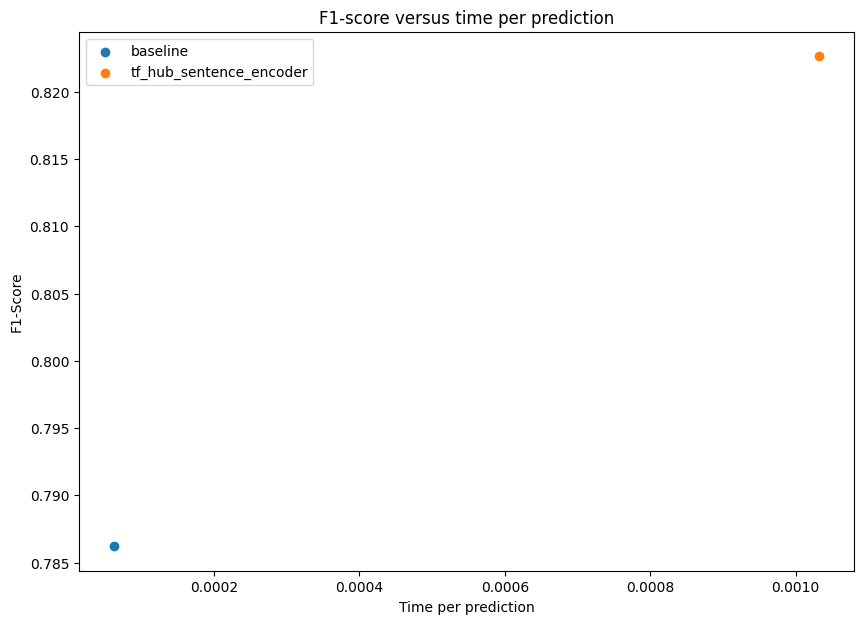

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_2_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

# 8. Make Predictions on specific format based on Kaggle:

id,target
0,0
2,0
3,1
9,0
11,0

In [68]:
import pandas as pd

def save_submission(test_df, predictions, filename="submission.csv"):
    # Create a DataFrame with 'id' and 'target' columns
    submission_df = pd.DataFrame({
        'id': test_df.index,
        'target': predictions
    })

    # Save the DataFrame to a CSV file
    submission_df.to_csv(filename, index=False)
    print(f"Submission saved to {filename}")

# Example usage:
# Assuming `test_df` is your DataFrame and `model_2_use` is your model
test_sentences = test_df["text"].to_list()
predictions = []

for test_sample in test_sentences:
    pred_prob = tf.squeeze(model_2_use.predict([test_sample]))
    pred = tf.round(pred_prob)
    predictions.append(int(pred))

# Save predictions to submission.csv
save_submission(test_df, predictions)

1/1 [==============================] - 0s 34ms/step
Submission saved to submission.csv


In [2]:
import pandas as pd 
submission_path = 'submission.csv'
test_path = '08-introduce-nlp-dataset/test.csv'

submission_df = pd.read_csv(submission_path)
test_df = pd.read_csv(test_path)

submission_df['id'] = test_df['id']
submission_df[:10]

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [4]:
submission_df.to_csv('updated_submission.csv', index=False)
print("File 'submission.csv' has been updated.")

File 'submission.csv' has been updated.
